In [1]:
import matplotlib.pyplot as plt
%matplotlib inline
import pandas as pd
import numpy as np
import seaborn as sns
from scipy import stats
import json
from sklearn.preprocessing import normalize
from sklearn import preprocessing
from sklearn.cross_validation import KFold,cross_val_score,train_test_split
import tensorflow as tf
from dateutil import parser
from sklearn.feature_selection import RFE
from sklearn.metrics import confusion_matrix
from sklearn.linear_model import LinearRegression
from sklearn.metrics import confusion_matrix
from sklearn import preprocessing
import statsmodels.api as sm

plt.rcParams['figure.figsize'] = (12,10)

G:\Anaconda\lib\site-packages\sklearn\cross_validation.py:41: DeprecationWarning: This module was deprecated in version 0.18 in favor of the model_selection module into which all the refactored classes and functions are moved. Also note that the interface of the new CV iterators are different from that of this module. This module will be removed in 0.20.
  "This module will be removed in 0.20.", DeprecationWarning)
G:\Anaconda\lib\site-packages\h5py\__init__.py:36: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters
G:\Anaconda\lib\site-packages\statsmodels\compat\pandas.py:56: FutureWarning: The pandas.core.datetools module is deprecated and will be removed in a future version. Please use the pandas.tseries module instead.
  from pandas.core import datetools


# Process Data

First we should read billboard chart data

In [2]:
billboard = pd.read_csv("billboard_chart_data.csv")  #read the billboard chart data which we use billboard API to get

In [3]:
billboard = billboard[['title','artist','rank', 'date']]

In [4]:
billboard.head()

,title,artist,rank,date
0,God's Plan,Drake,1,2018-02-17
1,Perfect,Ed Sheeran,2,2018-02-17
2,Finesse,Bruno Mars & Cardi B,3,2018-02-17
3,Havana,Camila Cabello Featuring Young Thug,4,2018-02-17
4,Rockstar,Post Malone Featuring 21 Savage,5,2018-02-17


In [5]:
billboard.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 100066 entries, 0 to 100065
Data columns (total 4 columns):
title     100066 non-null object
artist    100066 non-null object
rank      100066 non-null int64
date      100066 non-null object
dtypes: int64(1), object(3)
memory usage: 3.1+ MB


Then we read all the track's audion feature infomation and artist's information, there are about 6237 songs which has audio feature and it's rank, artist's popularity, follwers information. 

In [6]:
track = pd.read_csv("Full_data.csv")  # read all the track's audio feature data(Use Spotify API to get)

In [7]:
track.head()

,id,title,artist,track_id,artist_id,rank,hit,artist_popularity,followers,popularity,...,energy,key,loudness,mode,speechiness,acousticness,instrumentalness,liveness,valence,tempo
0,1,God's Plan,Drake,2XW4DbS6NddZxRPm5rMCeY,3TVXtAsR1Inumwj472S9r4,1,Yes,100,18311322,99,...,0.454,7,-9.488,1,0.0963,0.0244,0.000056,0.4980,0.344,77.170
1,2,Perfect,Ed Sheeran,0tgVpDi06FyKpA1z0VMD4v,6eUKZXaKkcviH0Ku9w2n3V,1,Yes,96,21431294,95,...,0.448,8,-6.312,1,0.0232,0.1630,0.000000,0.1060,0.168,95.050
2,3,Finesse,Bruno Mars & Cardi B,3Vo4wInECJQuz9BIBMOu8i,0du5cEVh5yTK9QJze8zA0C,3,Yes,91,11594549,95,...,0.859,5,-4.877,0,0.0996,0.0185,0.000000,0.0215,0.926,105.115
3,4,Havana,Camila Cabello Featuring Young Thug,1rfofaqEpACxVEHIZBJe6W,4nDoRrQiYLoBzwC5BhVJzF,1,Yes,91,3144195,97,...,0.523,2,-4.333,1,0.0300,0.1840,0.000036,0.1320,0.394,104.988
4,5,Rockstar,Post Malone Featuring 21 Savage,0OAAAdiHJKa2wlCKqaYXV7,246dkjvS1zLTtiykXe5h60,1,Yes,96,3309267,90,...,0.535,5,-6.637,0,0.0776,0.1300,0.000130,0.1430,0.127,159.764


In [8]:
track.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 6237 entries, 0 to 6236
Data columns (total 21 columns):
id                   6237 non-null int64
title                6237 non-null object
artist               6237 non-null object
track_id             6237 non-null object
artist_id            6237 non-null object
rank                 6237 non-null int64
hit                  6237 non-null object
artist_popularity    6237 non-null int64
followers            6237 non-null int64
popularity           6237 non-null int64
danceability         6237 non-null float64
energy               6237 non-null float64
key                  6237 non-null int64
loudness             6237 non-null float64
mode                 6237 non-null int64
speechiness          6237 non-null float64
acousticness         6237 non-null float64
instrumentalness     6237 non-null float64
liveness             6237 non-null float64
valence              6237 non-null float64
tempo                6237 non-null float64
dtypes: f

Then we need to merge the two table into one table, which will contain the track's audio feature and it's rank information.

In [9]:
merge_data = pd.merge(billboard,track,on=['title','artist']) #merge the two table by title and artist

In [10]:
del merge_data['rank_y']
del merge_data['hit']

We can use ".head()" to view the head of this table

In [11]:
merge_data.head()

,title,artist,rank_x,date,id,track_id,artist_id,artist_popularity,followers,popularity,...,energy,key,loudness,mode,speechiness,acousticness,instrumentalness,liveness,valence,tempo
0,God's Plan,Drake,1,2018-02-17,1,2XW4DbS6NddZxRPm5rMCeY,3TVXtAsR1Inumwj472S9r4,100,18311322,99,...,0.454,7,-9.488,1,0.0963,0.0244,0.000056,0.498,0.344,77.17
1,God's Plan,Drake,1,2018-02-10,1,2XW4DbS6NddZxRPm5rMCeY,3TVXtAsR1Inumwj472S9r4,100,18311322,99,...,0.454,7,-9.488,1,0.0963,0.0244,0.000056,0.498,0.344,77.17
2,God's Plan,Drake,1,2018-02-03,1,2XW4DbS6NddZxRPm5rMCeY,3TVXtAsR1Inumwj472S9r4,100,18311322,99,...,0.454,7,-9.488,1,0.0963,0.0244,0.000056,0.498,0.344,77.17
3,Perfect,Ed Sheeran,2,2018-02-17,2,0tgVpDi06FyKpA1z0VMD4v,6eUKZXaKkcviH0Ku9w2n3V,96,21431294,95,...,0.448,8,-6.312,1,0.0232,0.1630,0.000000,0.106,0.168,95.05
4,Perfect,Ed Sheeran,2,2018-02-10,2,0tgVpDi06FyKpA1z0VMD4v,6eUKZXaKkcviH0Ku9w2n3V,96,21431294,95,...,0.448,8,-6.312,1,0.0232,0.1630,0.000000,0.106,0.168,95.05


In [12]:
merge_data.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 89689 entries, 0 to 89688
Data columns (total 21 columns):
title                89689 non-null object
artist               89689 non-null object
rank_x               89689 non-null int64
date                 89689 non-null object
id                   89689 non-null int64
track_id             89689 non-null object
artist_id            89689 non-null object
artist_popularity    89689 non-null int64
followers            89689 non-null int64
popularity           89689 non-null int64
danceability         89689 non-null float64
energy               89689 non-null float64
key                  89689 non-null int64
loudness             89689 non-null float64
mode                 89689 non-null int64
speechiness          89689 non-null float64
acousticness         89689 non-null float64
instrumentalness     89689 non-null float64
liveness             89689 non-null float64
valence              89689 non-null float64
tempo                89689 non

We can find that the order of the table above is random after we merged the two table, so we need to sort these songs by their date and rank

In [13]:
merge_data = merge_data.sort_values(by=['date','rank_x'],ascending=True)  #sort the merger data according to date and rank_x

In [14]:
merge_data.to_csv("merge_data.csv", index = None)  #save data to csv file

In [15]:
df = pd.read_csv("merge_data.csv")

In [16]:
df.head()

,title,artist,rank_x,date,id,track_id,artist_id,artist_popularity,followers,popularity,...,energy,key,loudness,mode,speechiness,acousticness,instrumentalness,liveness,valence,tempo
0,I'm Your Angel,R. Kelly & Celine Dion,1,1998-12-12,7132,0QWFiyhOqFu9RP8qzP6z5L,2mxe0TnaNL039ysAj51xPQ,77,1465113,44,...,0.504,0,-7.260,1,0.0301,0.66900,0.000000,0.1100,0.266,112.681
1,Nobody's Supposed To Be Here,Deborah Cox,2,1998-12-12,7121,51QxenFmXlJXUN9mpvxlaL,601893mmW5hl1FBOykWZHG,55,160121,56,...,0.531,8,-5.300,1,0.0361,0.20200,0.000012,0.5950,0.399,119.957
2,Doo Wop (That Thing),Lauryn Hill,4,1998-12-12,7134,2Uu8IiLkLY0UXhCHka4Dlr,2Mu5NfyYm8n5iTomuKAEHl,70,816631,74,...,0.505,2,-8.926,0,0.2450,0.03930,0.000000,0.0923,0.495,99.935
3,From This Moment On,Shania Twain,5,1998-12-12,7161,7n2vETKqnlDt4670aVs5n5,5e4Dhzv426EvQe3aDb64jL,71,865667,50,...,0.514,7,-5.021,1,0.0271,0.38200,0.000000,0.1860,0.148,135.819
4,Love Like This,Faith Evans,7,1998-12-12,7140,7MQywXGHEev7JmwwIzMcao,5NDMothbpdpq2xHqSjrrWn,70,372926,60,...,0.551,0,-7.328,1,0.0616,0.00364,0.000000,0.0451,0.796,100.904


Label every songs “Yse” or "No" by their rank in given date, if rank lower than 30, label "Yes", otherwise, label "No" 

In [17]:
peak = []
for i in range(0, len(df)):
    tmp = []
    c = df['rank_x'][i]
    if c < 30:
        tmp.append("Yes")
    else:
        tmp.append("No")
    peak.append(tmp)
df_peak = pd.DataFrame(peak)
df_peak.columns = ['hit']

In [18]:
print(df_peak.info())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 89689 entries, 0 to 89688
Data columns (total 1 columns):
hit    89689 non-null object
dtypes: object(1)
memory usage: 700.8+ KB
None


Concat df with df_peak to get new result which cotains track audio feature and it's artist popularity and follower, and hit or not.

In [19]:
result = pd.concat([df, df_peak], axis=1) 

In [20]:
result.head()

,title,artist,rank_x,date,id,track_id,artist_id,artist_popularity,followers,popularity,...,key,loudness,mode,speechiness,acousticness,instrumentalness,liveness,valence,tempo,hit
0,I'm Your Angel,R. Kelly & Celine Dion,1,1998-12-12,7132,0QWFiyhOqFu9RP8qzP6z5L,2mxe0TnaNL039ysAj51xPQ,77,1465113,44,...,0,-7.260,1,0.0301,0.66900,0.000000,0.1100,0.266,112.681,Yes
1,Nobody's Supposed To Be Here,Deborah Cox,2,1998-12-12,7121,51QxenFmXlJXUN9mpvxlaL,601893mmW5hl1FBOykWZHG,55,160121,56,...,8,-5.300,1,0.0361,0.20200,0.000012,0.5950,0.399,119.957,Yes
2,Doo Wop (That Thing),Lauryn Hill,4,1998-12-12,7134,2Uu8IiLkLY0UXhCHka4Dlr,2Mu5NfyYm8n5iTomuKAEHl,70,816631,74,...,2,-8.926,0,0.2450,0.03930,0.000000,0.0923,0.495,99.935,Yes
3,From This Moment On,Shania Twain,5,1998-12-12,7161,7n2vETKqnlDt4670aVs5n5,5e4Dhzv426EvQe3aDb64jL,71,865667,50,...,7,-5.021,1,0.0271,0.38200,0.000000,0.1860,0.148,135.819,Yes
4,Love Like This,Faith Evans,7,1998-12-12,7140,7MQywXGHEev7JmwwIzMcao,5NDMothbpdpq2xHqSjrrWn,70,372926,60,...,0,-7.328,1,0.0616,0.00364,0.000000,0.0451,0.796,100.904,Yes


In [21]:
result.to_csv("billboard_charts.csv", index = None)

Calculate the number of days with the first day, because we want to use LSTM to predict the song's rank, so we have to calculate the time.

In [22]:
# Calculate the number of days with the first day
time = []
for i in range(0, len(result)):
    tmp = []
    if i == 0:
        tmp.append("0")
    else:
        df1 = parser.parse(result['date'][0])
        df2 = parser.parse(result['date'][i])
        df = (df2-df1).days
        #print(df)
        tmp.append(df)
    time.append(tmp)
df_days = pd.DataFrame(time)
df_days.columns= ['days']

Now, we get new columns "days", we concat this columns with result by using "concat()".

In [23]:
LSTM_data = pd.concat([result, df_days], axis=1)

In [24]:
LSTM_data.head()

,title,artist,rank_x,date,id,track_id,artist_id,artist_popularity,followers,popularity,...,loudness,mode,speechiness,acousticness,instrumentalness,liveness,valence,tempo,hit,days
0,I'm Your Angel,R. Kelly & Celine Dion,1,1998-12-12,7132,0QWFiyhOqFu9RP8qzP6z5L,2mxe0TnaNL039ysAj51xPQ,77,1465113,44,...,-7.260,1,0.0301,0.66900,0.000000,0.1100,0.266,112.681,Yes,0
1,Nobody's Supposed To Be Here,Deborah Cox,2,1998-12-12,7121,51QxenFmXlJXUN9mpvxlaL,601893mmW5hl1FBOykWZHG,55,160121,56,...,-5.300,1,0.0361,0.20200,0.000012,0.5950,0.399,119.957,Yes,0
2,Doo Wop (That Thing),Lauryn Hill,4,1998-12-12,7134,2Uu8IiLkLY0UXhCHka4Dlr,2Mu5NfyYm8n5iTomuKAEHl,70,816631,74,...,-8.926,0,0.2450,0.03930,0.000000,0.0923,0.495,99.935,Yes,0
3,From This Moment On,Shania Twain,5,1998-12-12,7161,7n2vETKqnlDt4670aVs5n5,5e4Dhzv426EvQe3aDb64jL,71,865667,50,...,-5.021,1,0.0271,0.38200,0.000000,0.1860,0.148,135.819,Yes,0
4,Love Like This,Faith Evans,7,1998-12-12,7140,7MQywXGHEev7JmwwIzMcao,5NDMothbpdpq2xHqSjrrWn,70,372926,60,...,-7.328,1,0.0616,0.00364,0.000000,0.0451,0.796,100.904,Yes,0


Save LSTM_data to csv file

In [25]:
LSTM_data.to_csv('LSTM_data.csv',index = None)

## Linear Model

First step is to read data, and then normalize these data

In [26]:
df = pd.read_csv("Full_data.csv") # read data
df = df[['rank','artist_popularity','followers','popularity','danceability','energy','key','loudness','mode','speechiness','acousticness'
         ,'instrumentalness','liveness','valence','tempo']]
data_zs = preprocessing.normalize(df, norm='l2') # normalization
data_zs = pd.DataFrame(data_zs)
data_zs.columns = ['rank','artist_popularity','followers','popularity','danceability','energy','key','loudness','mode','speechiness','acousticness'
         ,'instrumentalness','liveness','valence','tempo'] # add columns name

Second we get correlation matrix, which is used to investigate the dependence between multiple variables at the same time. The result is a table containing the correlation coefficients between each variable and the others  

In [27]:
data_zs.corr()

,rank,artist_popularity,followers,popularity,danceability,energy,key,loudness,mode,speechiness,acousticness,instrumentalness,liveness,valence,tempo
rank,1.000000,0.705908,-0.796614,0.770435,0.907101,0.947498,0.860511,-0.763978,0.744715,0.630041,0.694758,0.138772,0.799281,0.877603,0.890368
artist_popularity,0.705908,1.000000,-0.581229,0.941691,0.767426,0.771203,0.676481,-0.621750,0.471224,0.619311,0.529364,0.025657,0.541195,0.792695,0.796074
followers,-0.796614,-0.581229,1.000000,-0.702855,-0.899792,-0.802854,-0.831456,0.907869,-0.707081,-0.702654,-0.628552,-0.069452,-0.772676,-0.805326,-0.909881
popularity,0.770435,0.941691,-0.702855,1.000000,0.848601,0.835431,0.752888,-0.711136,0.548270,0.707142,0.618129,0.012811,0.644572,0.866959,0.856565
danceability,0.907101,0.767426,-0.899792,0.848601,1.000000,0.953093,0.886522,-0.907028,0.776749,0.803351,0.592107,0.131064,0.857685,0.943912,0.958921
energy,0.947498,0.771203,-0.802854,0.835431,0.953093,1.000000,0.857838,-0.800408,0.785333,0.729046,0.594591,0.141285,0.853236,0.939267,0.923472
key,0.860511,0.676481,-0.831456,0.752888,0.886522,0.857838,1.000000,-0.867666,0.706227,0.657342,0.703256,0.098196,0.767902,0.828896,0.872165
loudness,-0.763978,-0.621750,0.907869,-0.711136,-0.907028,-0.800408,-0.867666,1.000000,-0.765798,-0.783093,-0.588246,-0.210410,-0.783172,-0.775187,-0.911791
mode,0.744715,0.471224,-0.707081,0.548270,0.776749,0.785333,0.706227,-0.765798,1.000000,0.593416,0.377448,0.006030,0.771454,0.717171,0.765360
speechiness,0.630041,0.619311,-0.702654,0.707142,0.803351,0.729046,0.657342,-0.783093,0.593416,1.000000,0.503829,0.023720,0.763651,0.790136,0.730178


A heat map (or heatmap) is a graphical representation of data where the individual values contained in a matrix are represented as colors. From the heat map of correlation matrix, it is obvious that "followers" and "loudness" are negative relationship to rank, and "energy", "tempo","valence" are significant to rank. 

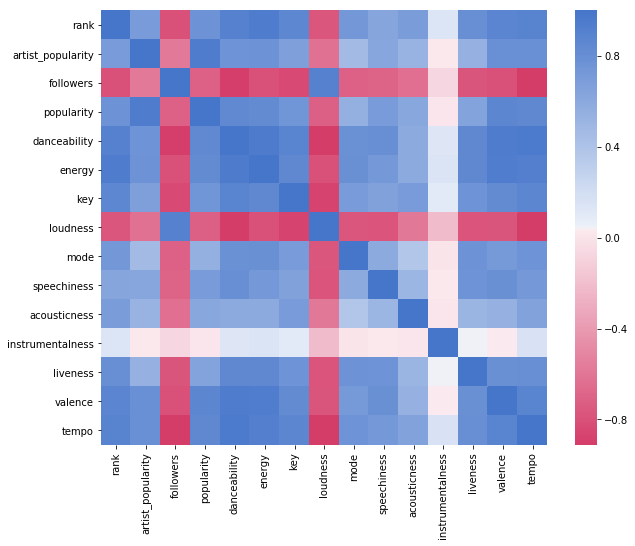

In [28]:
plt.rcParams['figure.figsize'] = (10,8)
cmap = sns.diverging_palette(0, 255, sep=1, n=256, as_cmap=True)
sns.heatmap(data_zs.corr(), cmap=cmap)


### Feature selection

RFE: Given an external estimator that assigns weights to features (e.g., the coefficients of a linear model), the goal of recursive feature elimination (RFE) is to select features by recursively considering smaller and smaller sets of features. First, the estimator is trained on the initial set of features and the importance of each feature is obtained either through a coef_ attribute or through a feature_importances_ attribute. Then, the least important features are pruned from current set of features. That procedure is recursively repeated on the pruned set until the desired number of features to select is eventually reached

We use RFE(recursive feature elimination) and heatmap to select the variable which we want to use them to do linear regression.

In [29]:
logreg = LinearRegression()
rfe = RFE(logreg, 10)
X = ['artist_popularity','followers','popularity','danceability','energy','key','loudness','mode','speechiness','acousticness'
,'instrumentalness','liveness','valence','tempo']
y = ['rank']
rfe = rfe.fit(data_zs[X], data_zs[y] )
print(rfe.support_)
print(rfe.ranking_)

[False False  True  True  True False  True  True  True  True  True  True
  True False]
[2 4 1 1 1 3 1 1 1 1 1 1 1 5]


G:\Anaconda\lib\site-packages\sklearn\utils\validation.py:578: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


The 10 variables are chosen by RFE, such as "popularity", "danceability", "energy", etc.

In [30]:
x = data_zs[["popularity","danceability",'energy','loudness','mode','speechiness','acousticness','instrumentalness','liveness','valence']]
X = sm.add_constant(x)
y = data_zs["rank"]
model = sm.OLS(y,X).fit()
model.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                   rank   R-squared:                       0.952
Model:                            OLS   Adj. R-squared:                  0.952
Method:                 Least Squares   F-statistic:                 1.226e+04
Date:                Fri, 27 Apr 2018   Prob (F-statistic):               0.00
Time:                        13:31:29   Log-Likelihood:                 23824.
No. Observations:                6237   AIC:                        -4.763e+04
Df Residuals:                    6226   BIC:                        -4.755e+04
Df Model:                          10                                         
Covariance Type:            nonrobust                                         
====================================================================================
                       coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------------
const             8.294e-05   6.78e-05      1.223      0.221      -5e-05       0.000
popularity          -0.5476      0.021    -26.554      0.000      -0.588      -0.507
danceability        56.7904      2.094     27.117      0.000      52.685      60.896
energy              55.3036      1.547     35.738      0.000      52.270      58.337
loudness             1.9943      0.101     19.742      0.000       1.796       2.192
mode                 7.5297      0.558     13.496      0.000       6.436       8.623
speechiness        -77.7716      2.478    -31.388      0.000     -82.629     -72.914
acousticness        66.4199      0.942     70.479      0.000      64.572      68.267
instrumentalness    17.0909      1.760      9.709      0.000      13.640      20.542
liveness            -2.8278      1.913     -1.478      0.139      -6.579       0.923
valence              9.0594      1.368      6.623      0.000       6.378      11.741
==============================================================================
Omnibus:                     4645.281   Durbin-Watson:                   1.999
Prob(Omnibus):                  0.000   Jarque-Bera (JB):         14857327.439
Skew:                           1.952   Prob(JB):                         0.00
Kurtosis:                     242.073   Cond. No.                     4.40e+04
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
[2] The condition number is large, 4.4e+04. This might indicate that there are
strong multicollinearity or other numerical problems.
"""

P-value: In statistical hypothesis testing, the p-value or probability value or asymptotic significance is the probability for a given statistical model that, when the null hypothesis is true, the statistical summary (such as the sample mean difference between two compared groups) would be the same as or of greater magnitude than the actual observed results.

Then we add one variable accroding to the heat map, we can find that besides "liveness", all other feature's p-value are all lower than 0.05, which means they are significant to rank.

In [31]:
x = data_zs[['artist_popularity','followers','popularity','danceability','energy','loudness','mode','speechiness','acousticness'
,'instrumentalness','valence']]
X = sm.add_constant(x)
y = data_zs["rank"]
model = sm.OLS(y,X).fit()
model.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                   rank   R-squared:                       0.953
Model:                            OLS   Adj. R-squared:                  0.952
Method:                 Least Squares   F-statistic:                 1.136e+04
Date:                Fri, 27 Apr 2018   Prob (F-statistic):               0.00
Time:                        13:31:29   Log-Likelihood:                 23879.
No. Observations:                6237   AIC:                        -4.773e+04
Df Residuals:                    6225   BIC:                        -4.765e+04
Df Model:                          11                                         
Covariance Type:            nonrobust                                         
=====================================================================================
                        coef    std err          t      P>|t|      [0.025      0.975]
-------------------------------------------------------------------------------------
const                -0.0431      0.008     -5.462      0.000      -0.059      -0.028
artist_popularity     0.3096      0.045      6.944      0.000       0.222       0.397
followers             0.0431      0.008      5.464      0.000       0.028       0.059
popularity           -0.7865      0.034    -22.928      0.000      -0.854      -0.719
danceability         61.5355      2.137     28.801      0.000      57.347      65.724
energy               51.0012      1.481     34.428      0.000      48.097      53.905
loudness              1.7610      0.111     15.893      0.000       1.544       1.978
mode                  7.4794      0.565     13.246      0.000       6.373       8.586
speechiness         -83.2583      2.401    -34.679      0.000     -87.965     -78.552
acousticness         69.8124      0.995     70.177      0.000      67.862      71.763
instrumentalness     14.9734      1.798      8.327      0.000      11.448      18.499
valence              11.9002      1.296      9.183      0.000       9.360      14.440
==============================================================================
Omnibus:                     4732.546   Durbin-Watson:                   1.998
Prob(Omnibus):                  0.000   Jarque-Bera (JB):         16243740.217
Skew:                           2.017   Prob(JB):                         0.00
Kurtosis:                     252.979   Cond. No.                     5.39e+04
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
[2] The condition number is large, 5.39e+04. This might indicate that there are
strong multicollinearity or other numerical problems.
"""

### Cross-validation

Cross-validation is primarily a way of measuring the predictive performance of a statistical model

In [34]:
x = data_zs[['artist_popularity','followers','popularity','danceability','energy','loudness','mode','speechiness','acousticness'
,'instrumentalness','valence']]
y = data_zs["rank"]
X=np.array(X)
y=np.array(y)
X_train, X_test, y_train, y_test = train_test_split(X,y,test_size=0.3,random_state=0)
clf = LinearRegression()
scores = cross_val_score(clf, X_test, y_test, cv=6)
print(scores)
print("Accuracy: %0.2f (+/- %0.2f)" % (scores.mean(), scores.std() * 2))

[0.91060056 0.89483569 0.65432276 0.88873608 0.96179543 0.96873287]
Accuracy: 0.88 (+/- 0.21)


We can see that by using Cross-validation, the Accuracy of this model is 88%

## Logistic Regression 

Since we have two labels("Yes" and "No") in our model, which we can use Logistic Regression to predict whether the track can be hit or not

In [35]:
from sklearn.linear_model import LogisticRegression
import statsmodels.api as sm
from scipy import stats
stats.chisqprob = lambda chisq, df: stats.chi2.sf(chisq, df)

The first step to build Logistic Regression is to replace "Yes" or "No" to 1 and 0,then what we need to do is to scaler the data, which is significant to build Logistic Regression

In [36]:
data = pd.read_csv("Full_data.csv")
data.hit.replace(('Yes', 'No'), (1, 0), inplace=True)
max_abs_scaler = preprocessing.MaxAbsScaler()
data_zs = max_abs_scaler.fit_transform(data[['artist_popularity','followers','popularity','energy','loudness','mode','tempo']])
data_zs = pd.DataFrame(data_zs)
data_zs.columns = ['artist_popularity','followers','popularity','energy','loudness','mode','tempo']

In [37]:
data_zs.head()

,artist_popularity,followers,popularity,energy,loudness,mode,tempo
0,1.00,0.854395,1.000000,0.455823,-0.430979,1.0,0.361051
1,0.96,0.999971,0.959596,0.449799,-0.286714,1.0,0.444705
2,0.91,0.540994,0.959596,0.862450,-0.221531,0.0,0.491796
3,0.91,0.146706,0.979798,0.525100,-0.196820,1.0,0.491202
4,0.96,0.154408,0.909091,0.537149,-0.301476,0.0,0.747479


In [38]:
L_model =sm.Logit(data['hit'],data_zs).fit()
L_model.summary()

Optimization terminated successfully.
         Current function value: 0.582265
         Iterations 6


<class 'statsmodels.iolib.summary.Summary'>
"""
                           Logit Regression Results                           
==============================================================================
Dep. Variable:                    hit   No. Observations:                 6237
Model:                          Logit   Df Residuals:                     6230
Method:                           MLE   Df Model:                            6
Date:                Fri, 27 Apr 2018   Pseudo R-squ.:                 0.09279
Time:                        14:26:02   Log-Likelihood:                -3631.6
converged:                       True   LL-Null:                       -4003.0
                                        LLR p-value:                3.328e-157
=====================================================================================
                        coef    std err          z      P>|z|      [0.025      0.975]
-------------------------------------------------------------------------------------
artist_popularity    -3.0881      0.286    -10.784      0.000      -3.649      -2.527
followers             1.6158      0.179      9.044      0.000       1.266       1.966
popularity            6.0623      0.276     21.999      0.000       5.522       6.602
energy               -0.9523      0.167     -5.716      0.000      -1.279      -0.626
loudness              2.7656      0.309      8.946      0.000       2.160       3.371
mode                 -0.1689      0.060     -2.824      0.005      -0.286      -0.052
tempo                -1.2393      0.205     -6.043      0.000      -1.641      -0.837
=====================================================================================
"""

From the summary, we can see that all variables which we selected are significant for predict whether the track can be hit or not sicne all the p-value are lower than 0.05.

##  Cross-validate the model

In [39]:
X = data_zs
y = data["hit"]
X=np.array(X)
y=np.array(y)
X_train, X_test, y_train, y_test = train_test_split(X,y,test_size=0.2,random_state=123)
clf = LogisticRegression()
clf.fit(X_train, y_train)
scores = cross_val_score(clf, X_test, y_test, cv=10)
print(scores)
print("Accuracy: %0.2f (+/- %0.2f)" % (scores.mean(), scores.std() * 2))
['popularity','danceability','energy','key','loudness','valence','tempo']

[0.64       0.688      0.664      0.696      0.672      0.688
 0.736      0.656      0.69354839 0.69354839]
Accuracy: 0.68 (+/- 0.05)


['popularity', 'danceability', 'energy', 'key', 'loudness', 'valence', 'tempo']

The Accuracy of this model is 68%

## Confusion Matrix

In the field of machine learning and specifically the problem of statistical classification, a confusion matrix, also known as an error matrix, is a specific table layout that allows visualization of the performance of an algorithm, typically a supervised learning one (in unsupervised learning it is usually called a matching matrix)

In [40]:
y_pred = clf.predict(X_test)
matrix = confusion_matrix(y_test, y_pred)
print(matrix)

[[730  90]
 [319 109]]


From the Confusion Matrix, we can find that the TP(true positive) is 730, the TN(true negative) is 319, so the accuracy of predicting the song can be hit is 69.5%, and the FP(false positive) is 90, FN(false negative) is 109, so the accuracy of the song can not be hit is 54.7%.

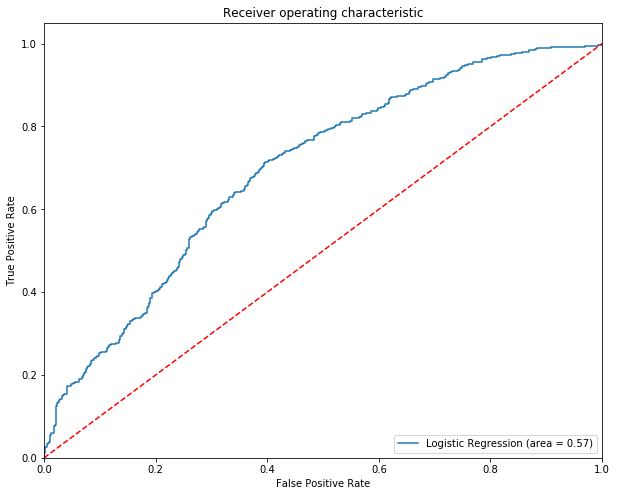

In [41]:
from sklearn.metrics import roc_auc_score
from sklearn.metrics import roc_curve
logit_roc_auc = roc_auc_score(y_test, clf.predict(X_test))
fpr, tpr, thresholds = roc_curve(y_test, clf.predict_proba(X_test)[:,1])
plt.figure()
plt.plot(fpr, tpr, label='Logistic Regression (area = %0.2f)' % logit_roc_auc)
plt.plot([0, 1], [0, 1],'r--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver operating characteristic')
plt.legend(loc="lower right")
plt.savefig('Log_ROC')
plt.show()

The ROC plot shows that the area is only about 0.57, and the blue line is close to the diagonal， so the Logistic Regression do not fit very well

## Deep Learning model（CNN）

To increased the accuracy of our model, We want to use CNN to predict whether a given track can reach top 30 by using their artist's popularity, followers, and audion feature, audio analysis information which we get on spotify api.

In [43]:
data = pd.read_csv("Full_data.csv")

In [44]:
data.head()

,id,title,artist,track_id,artist_id,rank,hit,artist_popularity,followers,popularity,...,energy,key,loudness,mode,speechiness,acousticness,instrumentalness,liveness,valence,tempo
0,1,God's Plan,Drake,2XW4DbS6NddZxRPm5rMCeY,3TVXtAsR1Inumwj472S9r4,1,Yes,100,18311322,99,...,0.454,7,-9.488,1,0.0963,0.0244,0.000056,0.4980,0.344,77.170
1,2,Perfect,Ed Sheeran,0tgVpDi06FyKpA1z0VMD4v,6eUKZXaKkcviH0Ku9w2n3V,1,Yes,96,21431294,95,...,0.448,8,-6.312,1,0.0232,0.1630,0.000000,0.1060,0.168,95.050
2,3,Finesse,Bruno Mars & Cardi B,3Vo4wInECJQuz9BIBMOu8i,0du5cEVh5yTK9QJze8zA0C,3,Yes,91,11594549,95,...,0.859,5,-4.877,0,0.0996,0.0185,0.000000,0.0215,0.926,105.115
3,4,Havana,Camila Cabello Featuring Young Thug,1rfofaqEpACxVEHIZBJe6W,4nDoRrQiYLoBzwC5BhVJzF,1,Yes,91,3144195,97,...,0.523,2,-4.333,1,0.0300,0.1840,0.000036,0.1320,0.394,104.988
4,5,Rockstar,Post Malone Featuring 21 Savage,0OAAAdiHJKa2wlCKqaYXV7,246dkjvS1zLTtiykXe5h60,1,Yes,96,3309267,90,...,0.535,5,-6.637,0,0.0776,0.1300,0.000130,0.1430,0.127,159.764


In [45]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 6237 entries, 0 to 6236
Data columns (total 21 columns):
id                   6237 non-null int64
title                6237 non-null object
artist               6237 non-null object
track_id             6237 non-null object
artist_id            6237 non-null object
rank                 6237 non-null int64
hit                  6237 non-null object
artist_popularity    6237 non-null int64
followers            6237 non-null int64
popularity           6237 non-null int64
danceability         6237 non-null float64
energy               6237 non-null float64
key                  6237 non-null int64
loudness             6237 non-null float64
mode                 6237 non-null int64
speechiness          6237 non-null float64
acousticness         6237 non-null float64
instrumentalness     6237 non-null float64
liveness             6237 non-null float64
valence              6237 non-null float64
tempo                6237 non-null float64
dtypes: f

In [46]:
data.duplicated().sum()

0

In [47]:
data.describe()

,id,rank,artist_popularity,followers,popularity,danceability,energy,key,loudness,mode,speechiness,acousticness,instrumentalness,liveness,valence,tempo
count,6237.000000,6237.000000,6237.000000,6.237000e+03,6237.000000,6237.000000,6237.000000,6237.000000,6237.000000,6237.000000,6237.000000,6237.000000,6237.000000,6237.000000,6237.000000,6237.000000
mean,3515.977233,46.833093,72.287959,2.818100e+06,57.089145,0.625627,0.698398,5.255892,-5.833668,0.678211,0.099974,0.161373,0.008434,0.185531,0.518813,121.944461
std,2095.961730,29.967952,14.870323,4.272673e+06,14.185772,0.144532,0.170741,3.563445,2.146704,0.467200,0.101689,0.203845,0.066063,0.141792,0.223985,28.966124
min,1.000000,1.000000,0.000000,2.000000e+00,0.000000,0.113000,0.056500,0.000000,-22.015000,0.000000,0.022400,0.000003,0.000000,0.016400,0.034900,51.316000
25%,1683.000000,20.000000,64.000000,3.556930e+05,48.000000,0.529000,0.587000,2.000000,-6.965000,0.000000,0.035100,0.017300,0.000000,0.094400,0.338000,98.011000
50%,3454.000000,46.000000,75.000000,1.083347e+06,58.000000,0.628000,0.723000,5.000000,-5.531000,1.000000,0.052900,0.072600,0.000000,0.129000,0.520000,120.637000
75%,5329.000000,73.000000,82.000000,3.019306e+06,67.000000,0.725000,0.832000,8.000000,-4.341000,1.000000,0.120000,0.231000,0.000017,0.243000,0.694000,140.171000
max,7234.000000,100.000000,100.000000,2.143193e+07,99.000000,0.994000,0.996000,11.000000,-0.463000,1.000000,0.765000,0.986000,0.982000,0.987000,0.976000,213.737000


## Split data

We want to split our data into Train data(75%) and Test data(25%)

In [48]:
x_train ,x_test = train_test_split(data,test_size=0.25)  #split data into train data and test data

In [49]:
x_train.head()

,id,title,artist,track_id,artist_id,rank,hit,artist_popularity,followers,popularity,...,energy,key,loudness,mode,speechiness,acousticness,instrumentalness,liveness,valence,tempo
173,187,Transportin',Kodak Black,1WIZiOuNO3woKfdlSK2gNn,46SHBwWsqBkxI7EeeBEQG7,46,No,87,2744896,81,...,0.660,10,-4.860,0,0.0726,0.03190,0.000000,0.1030,0.257,94.053
423,457,Hard Times,Paramore,0w5Bdu51Ka25Pf3hojsKHh,74XFHRwlV6OrjEM0A2NCMF,90,No,80,2815000,75,...,0.818,5,-5.379,0,0.0334,0.00647,0.000005,0.0219,0.916,119.965
3740,4193,When You Look Me In The Eyes,Jonas Brothers,6YnauKvhKMFOX63RwmiCwH,7gOdHgIoIKoe4i9Tta6qdD,25,Yes,66,941209,57,...,0.767,2,-3.685,1,0.0337,0.02690,0.000000,0.2700,0.506,136.047
843,911,Hello,Adele,0ENSn4fwAbCGeFGVUbXEU3,4dpARuHxo51G3z768sgnrY,1,Yes,85,8650583,69,...,0.451,5,-6.095,0,0.0347,0.33600,0.000000,0.0872,0.289,157.966
5983,6925,So Anxious,Ginuwine,2zbjlcLi1VQWqDNYdhyx1l,7r8RF1tN2A4CiGEplkp1oP,16,Yes,70,817542,60,...,0.395,6,-11.959,0,0.0366,0.27900,0.000002,0.4680,0.661,96.085


In [50]:
x_test.head()

,id,title,artist,track_id,artist_id,rank,hit,artist_popularity,followers,popularity,...,energy,key,loudness,mode,speechiness,acousticness,instrumentalness,liveness,valence,tempo
1548,1671,Burn,Ellie Goulding,0xMd5bcWTbyXS7wPrBtZA6,0X2BH1fck6amBIoJhDVmmJ,13,Yes,81,4487371,68,...,0.772,10,-5.031,0,0.0476,0.29600,0.000000,0.1010,0.323,87.038
2739,3018,I Like It,Enrique Iglesias Featuring Pitbull,4nVyHATevhl5RC6Qmoko5H,7qG3b048QCHVRO5Pv1T5lw,4,Yes,84,5710383,63,...,0.935,10,-2.739,0,0.1070,0.02530,0.000000,0.0653,0.730,129.048
4232,4794,A Public Affair,Jessica Simpson,1gFMesXcHHtIUhwzxYFOtz,2tFN9ubMXEhdAQvdQxcsma,14,Yes,54,338802,41,...,0.860,11,-3.878,0,0.0339,0.00525,0.000192,0.4040,0.835,124.052
2401,2630,Cost Of Livin',Ronnie Dunn,64SgS8XyiJWFSz3YoMyYcE,1iLuTmIgxCEiEllDSWkeIy,86,No,53,31417,49,...,0.290,4,-7.896,1,0.0349,0.89500,0.000000,0.0959,0.283,148.393
6025,6976,I Will Remember You (Live),Sarah McLachlan,7fEfH6kqMu1Gjes7yi5BHO,4NgNsOXSwIzXlUIJcpnNUp,14,Yes,63,301721,36,...,0.394,9,-11.749,1,0.0292,0.51500,0.000005,0.9780,0.355,151.799


In [51]:
x_train.to_csv('Train_data.csv', index = False)
x_test.to_csv("Test_data.csv",index = False)

To build CNN model, we need to initialise weights and bias for the filter, the weight_variable is truncated_normal. and the bias_variable is constant.

In [52]:
def weight_variable(shape, name = "ConV"):    
    return tf.Variable( tf.truncated_normal(shape, stddev=0.1) )  
def bias_variable(shape,name = "Fc"):    
    return tf.Variable( tf.constant(0.1, shape=shape) ) 

Setup the filter input shape for tf.nn.conv_2d, the strides is 1

In [56]:
def conv2d(x, W):    
    return tf.nn.conv2d(x, W, strides=[1, 1, 1, 1], padding='SAME') 

Performs the max pooling on the input, the kernel size is 2*2, and the strides is 2 

In [57]:
def max_pool_2x2(x):    
    return tf.nn.max_pool(x, ksize=[1, 2, 2, 1], strides=[1, 2, 2, 1], padding='SAME')  

define the read data function, we choose 14 features of each track to predict whether the track is hit or not

In [58]:
def read_data(file_name):
    """ Read data """
    path = file_name + ".csv"
    df = pd.read_csv(path)
    df.hit.replace(('Yes', 'No'), (1, 0), inplace=True)
    
    # Fixed params
    n_class = 2
    n_steps = 14
    n_channels = 14
    
    "labels"
    labels = df["hit"]
    
    # Initiate array
    X = np.zeros((len(labels), n_steps, n_channels))
    
    for i in range(0,len(labels)):
        for j in range(0, n_steps):
            a = df.loc[i][7:21].tolist()
            tmp = []
            tmp = tmp + a
            tmp = np.asarray(tmp)
            X[i,j,:] = tmp
        if i%100 == 0:
            print(i)  
    return X, labels

Standardize train and test

In [59]:
def standardize(train, test):
    # Standardize train and test
    X_train = (train - np.mean(train, axis=0)[None,:,:]) / np.std(train, axis=0)[None,:,:]
    X_test = (test - np.mean(test, axis=0)[None,:,:]) / np.std(test, axis=0)[None,:,:]
    return X_train, X_test

we use one hot to label 1 and 0, this function Return a 2-D array with ones on the diagonal and zeros elsewhere.

In [61]:
def one_hot(labels, n_class = 2):
    expansion = np.eye(n_class) #Return a 2-D array with ones on the diagonal and zeros elsewhere.
    y = expansion[:, labels-1].T
    assert y.shape[1] == n_class, "Wrong number of labels!"
    return y

In [62]:
def next_batch(train_data, train_target, batch_size):  
    idx = [ i for i in range(0,len(train_target)) ]  
    np.random.shuffle(idx);  
    batch_data = []; batch_target = [];  
    for i in range(0,batch_size):  
        batch_data.append(train_data[idx[i]]);  
        batch_target.append(train_target[idx[i]])  
    return batch_data, batch_target

In [63]:
x_train, labels_train = read_data("Train_data") # train
x_test, labels_test = read_data("Test_data") # test

0
100
200
300
400
500
600
700
800
900
1000
1100
1200
1300
1400
1500
1600
1700
1800
1900
2000
2100
2200
2300
2400
2500
2600
2700
2800
2900
3000
3100
3200
3300
3400
3500
3600
3700
3800
3900
4000
4100
4200
4300
4400
4500
4600
0
100
200
300
400
500
600
700
800
900
1000
1100
1200
1300
1400
1500


In [64]:
print ("Training data shape: N = {:d}, steps = {:d}, channels = {:d}".format(x_train.shape[0],
                                                                             x_train.shape[1],
                                                                             x_train.shape[2]))
print ("Test data shape: N = {:d}, steps = {:d}, channels = {:d}".format(x_test.shape[0],
                                                                   
                                                                         x_test.shape[1],
                                                                         x_test.shape[2]))

Training data shape: N = 4677, steps = 14, channels = 14
Test data shape: N = 1560, steps = 14, channels = 14


standardize the training data and test data

In [65]:
X_train, Y_test = standardize(x_train, x_test)  

one hot label, One hot encoding is a process by which categorical variables are converted into a form that could be provided to ML algorithms to do a better job in prediction

In [66]:
y_tr = one_hot(labels_train)
y_test = one_hot(labels_test)

In [67]:
train_data = X_train  
train_target = y_tr  
test_data = Y_test     
test_target = y_test 

### Hyperparameters

In [83]:
seq_len = 14  # seq_len = steps
n_channels = 14 # feature
n_classes = 2 # Yes or No

Declare the training data placeholders

In [84]:
x = tf.placeholder(tf.float32, [None, seq_len, n_channels], name = 'inputs')
y = tf.placeholder(tf.float32, [None, n_classes], name = 'labels')
keep_prob = tf.placeholder(tf.float32, name = 'keep') # keep_probability   

In [85]:
epochs_num = 5000   
batch_size = 50

 ## Convolutional Layer 1

Define the filter size(2*2), feature map to 20, then define the bias size, which is the number of convolution kernel, use Relu activation

In [86]:
W_conv1 = weight_variable([3, 3, 1, 20],name = "W")     
b_conv1 = bias_variable([20], name = "b")  
x_image = tf.reshape(x, [-1, 14, 14, 1])  # reshape  
h_conv1 = tf.nn.relu(conv2d(x_image, W_conv1) + b_conv1)  # relu activation function  

## Pooling Layer 1

output is [7,7,20,40]

In [87]:
h_pool1 = max_pool_2x2(h_conv1) 

## Convolutional Layer 2

The second conv2 kernal size is 3*3

In [88]:
W_conv2 = weight_variable([3, 3, 20, 40])    
b_conv2 = bias_variable([40])    
h_conv2 = tf.nn.relu( conv2d(h_pool1, W_conv2) + b_conv2 ) 

## Pooling Layer #2

In [89]:
h_pool2 = max_pool_2x2(h_conv2) # 输出[4，4,40,100]  

After the second pooling layer, the output shape is [4,4,40]

## Dense Layer 1

In [90]:
W_fc1 = weight_variable([4 * 4 * 40, 100], name ="W")    
b_fc1 = bias_variable([100], name = "b")    
h_pool2_flat = tf.reshape(h_pool2, [-1, 4*4*40])    
h_fc1 = tf.nn.relu( tf.matmul(h_pool2_flat, W_fc1) + b_fc1 )     
h_fc1_drop = tf.nn.dropout(h_fc1, keep_prob)  #some hidden node weight is not kept

## Dense Layer 2

In [92]:
W_fc2 = weight_variable([100, 2], name = "W")    
b_fc2 = bias_variable([2], name = "b")    
y_conv=tf.nn.softmax( tf.matmul(h_fc1_drop, W_fc2) + b_fc2 )

## Begin Trainning

In [93]:

sess = tf.InteractiveSession() 

cross_entropy = -tf.reduce_sum(y*tf.log(y_conv)) #cost function

train_step = tf.train.AdamOptimizer(1e-4).minimize(cross_entropy) # Gradient estimation  

correct_prediction = tf.equal(tf.argmax(y_conv,1), tf.argmax(y,1))  

probabilities=y_conv

accuracy = tf.reduce_mean(tf.cast(correct_prediction, "float"))   

sess.run(tf.initialize_all_variables()) 

train_acc = []
for i in range(epochs_num): 

    batch_data, batch_target = next_batch(train_data,train_target,batch_size) 
    
    if i%100 == 0:    
        train_accuracy = accuracy.eval(feed_dict={ x:batch_data, y: batch_target, keep_prob: 1.0} )    
        print ("step %d, training accuracy %.3f"%(i, train_accuracy))   
    if i%10 ==0:    
        train_accuracy = accuracy.eval(feed_dict={ x:batch_data, y: batch_target, keep_prob: 1.0} )
        
    train_step.run(feed_dict={x: batch_data, y:batch_target, keep_prob: 0.5})   # keep_prob is 0.5  
  
print("Training finished")    
print("test accuracy %.3f" % accuracy.eval(feed_dict={ x: test_data, y:test_target , keep_prob: 1.0}) )


Instructions for updating:
Use `tf.global_variables_initializer` instead.
step 0, training accuracy 0.280
step 100, training accuracy 0.700
step 200, training accuracy 0.700
step 300, training accuracy 0.640
step 400, training accuracy 0.840
step 500, training accuracy 0.660
step 600, training accuracy 0.760
step 700, training accuracy 0.780
step 800, training accuracy 0.720
step 900, training accuracy 0.740
step 1000, training accuracy 0.660
step 1100, training accuracy 0.720
step 1200, training accuracy 0.720
step 1300, training accuracy 0.700
step 1400, training accuracy 0.720
step 1500, training accuracy 0.740
step 1600, training accuracy 0.660
step 1700, training accuracy 0.800
step 1800, training accuracy 0.780
step 1900, training accuracy 0.820
step 2000, training accuracy 0.720
step 2100, training accuracy 0.780
step 2200, training accuracy 0.740
step 2300, training accuracy 0.840
step 2400, training accuracy 0.660
step 2500, training accuracy 0.820
step 2600, training accuracy

### Compute confusion matrix

In [94]:
test_predict = correct_prediction.eval(feed_dict={ x: test_data, y:test_target , keep_prob: 1.0})

In [95]:
print(test_predict)

[ True  True False ...  True False False]


In [96]:
test_predict = pd.DataFrame(test_predict)

In [97]:
test_predict.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1560 entries, 0 to 1559
Data columns (total 1 columns):
0    1560 non-null bool
dtypes: bool(1)
memory usage: 1.6 KB


In [98]:
test_predict.to_csv("test.csv")

In [99]:
test_target = pd.DataFrame(test_target)

In [100]:
test_target .to_csv("test_target.csv")

transform one hot to True or False

In [102]:
target = []
for i in range(0,len(test_target)):
    tmp = []
    if test_target.loc[i][0] == 1:
        tmp.append(False)
    else:
        tmp.append(True)
    target.append(tmp)
test_1 = pd.DataFrame(target)
test_1.columns= ['hit']

In [103]:
test_1.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1560 entries, 0 to 1559
Data columns (total 1 columns):
hit    1560 non-null bool
dtypes: bool(1)
memory usage: 1.6 KB


In [104]:
cnf_rf = confusion_matrix(test_1,test_predict)

In [105]:
print(cnf_rf)  

[[324 221]
 [118 897]]


### ROC

In [106]:
probabilities=y_conv
pro = probabilities.eval(feed_dict={ x: test_data, y:test_target , keep_prob: 1.0})

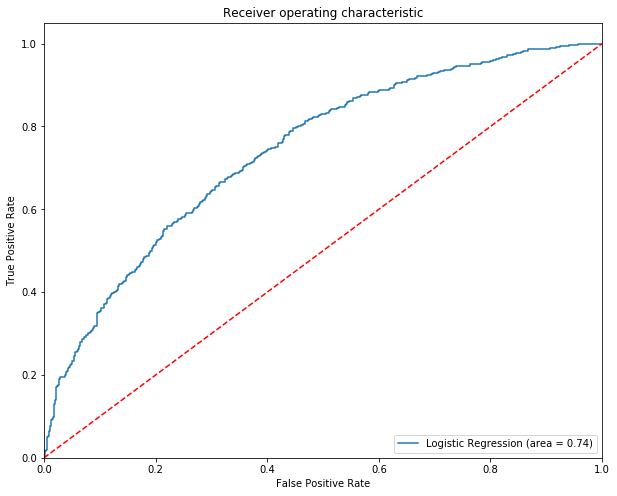

In [107]:
from sklearn.metrics import roc_auc_score
from sklearn.metrics import roc_curve
logit_roc_auc = roc_auc_score(test_1,pro[:,1] )
fpr, tpr, thresholds = roc_curve(test_1, pro[:,1])
plt.figure()
plt.plot(fpr, tpr, label='Logistic Regression (area = %0.2f)' % logit_roc_auc)
plt.plot([0, 1], [0, 1],'r--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver operating characteristic')
plt.legend(loc="lower right")
plt.savefig('Log_ROC')
plt.show()

The AUC is 0.74, which is much better than 0.57.

# LSTM

(Some part of code are copyed from (https://github.com/healthDataScience/deep-learning-HAR) )

In [109]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
import tensorflow as tf
config = tf.ConfigProto()
config.gpu_options.allow_growth = True
sess = tf.Session(config=config)

we select 15 features to predict the rank

In [110]:
data = pd.read_csv("LSTM_data.csv")
data = data[['artist_popularity','followers','popularity','danceability','energy','key','loudness','mode',
        'speechiness','acousticness','instrumentalness','liveness','valence','tempo','days','hit']]

Since we want to use time series data, we choose the first 80000 rows data as training, the left 9000 rows data are chosen as test data. 

In [111]:
data[0:80000].to_csv("Train_data_lstm.csv",index = None)
data[80000:len(data)].to_csv("Test_data_lstm.csv",index = None)

In [112]:
def read_data(file_name):
    """ Read data """
    path = file_name + ".csv"
    df = pd.read_csv(path)
    df = df[['artist_popularity','followers','popularity','danceability','energy','key','loudness','mode',
        'speechiness','acousticness','instrumentalness','liveness','valence','tempo','days','hit']]
    df.hit.replace(("Yes", "No"), (1, 0), inplace=True)
    # Fixed params
    n_class = 2
    n_steps = 1
    n_channels = 15
    
    "labels"
    labels = df["hit"]
    
    # Initiate array
    X = np.zeros((len(labels), n_steps, n_channels))
    
    for i in range(0,len(labels)):
        for j in range(0, n_steps):
            #seg = segments[j]
            a = df.loc[i][0:15].tolist() # 15 channels
            tmp = []
            tmp = tmp + a
            tmp = np.asarray(tmp)
            X[i,j,:] = tmp
        if i%20000 == 0:
            print(i)  
    return X, labels

Standardize train and test

In [113]:
def standardize(train, test):
    # Standardize train and test
    X_train = (train - np.mean(train, axis=0)[None,:,:]) / np.std(train, axis=0)[None,:,:]
    X_test = (test - np.mean(test, axis=0)[None,:,:]) / np.std(test, axis=0)[None,:,:]
    return X_train, X_test

In [114]:
def one_hot(labels, n_class = 2):
    expansion = np.eye(n_class)  # generate diagonal matrix
    y = expansion[:, labels-1].T  # Transpose the matrix
    assert y.shape[1] == n_class, "Wrong number of labels!"
    return y

In [115]:
def get_batches(X, y, batch_size):
    n_batches = len(X) // batch_size
    X, y = X[:n_batches*batch_size], y[:n_batches*batch_size]
    # Loop over batches and yield
    for b in range(0, len(X), batch_size):
        yield X[b:b+batch_size], y[b:b+batch_size]

In [116]:
x_train, labels_train = read_data("Train_data_lstm") # train
x_test, labels_test = read_data("Test_data_lstm") # test

0
20000
40000
60000
0


In [117]:
X_train, X_test = standardize(x_train, x_test)

We want to keep the order of the data, so we trun of the shuffle 

In [118]:
X_tr, X_vld, lab_tr, lab_vld = train_test_split(X_train, labels_train, 
                                                shuffle=False,
                                                stratify = None)

In [119]:
y_tr = one_hot(lab_tr)
y_vld = one_hot(lab_vld)
y_test = one_hot(labels_test)

### Hyperparameters

In [120]:
# Imports
import tensorflow as tf

lstm_size = 45         # 3 times the amount of channels
lstm_layers = 2        # Number of layers
batch_size = 200       # Batch size
seq_len = 1          # Number of steps
learning_rate = 0.0001  # Learning rate (default is 0.001)
epochs = 200

# Fixed
n_classes = 2
n_channels = 15

### Construct the graph

In [121]:
graph = tf.Graph()

# Construct placeholders
with graph.as_default():
    inputs_ = tf.placeholder(tf.float32, [None, seq_len, n_channels], name = 'inputs')
    labels_ = tf.placeholder(tf.float32, [None, n_classes], name = 'labels')
    keep_prob_ = tf.placeholder(tf.float32, name = 'keep')
    learning_rate_ = tf.placeholder(tf.float32, name = 'learning_rate')

Construct the LSTM inputs and LSTM cells

In [122]:
with graph.as_default():
   
    lstm_in = tf.transpose(inputs_, [1,0,2]) # （N, seq_len, channels ）reshape into (seq_len, N, channels)
    lstm_in = tf.reshape(lstm_in, [-1, n_channels]) # Now (seq_len*N, n_channels)
    
    # To cells
    lstm_in = tf.layers.dense(lstm_in, lstm_size, activation=tf.nn.relu) # or tf.nn.relu, tf.nn.sigmoid, tf.nn.tanh?
    
    # Open up the tensor into a list of seq_len pieces
    lstm_in = tf.split(lstm_in, seq_len, 0)
    
    # Add LSTM layers
    lstm = tf.contrib.rnn.BasicLSTMCell(lstm_size)  # Add basic LTSM Cell
    
    drop = tf.contrib.rnn.DropoutWrapper(lstm, output_keep_prob=keep_prob_)
    
    cell = tf.contrib.rnn.MultiRNNCell([drop] * lstm_layers) # Add multipul RNN Cell
    
    initial_state = cell.zero_state(batch_size, tf.float32)  

Instructions for updating:
Use the retry module or similar alternatives.


First, we need to create a recurrent neural network specified by RNNCell cell, we only need the last output tensor to pass into a classifier. To avoid gradient explosion, we have three steps: 1.Compute the gradients with compute_gradients() 2.Process the gradients as you wish 3.Apply the processed gradients with apply_gradients().

In [123]:
with graph.as_default():
    #Creates a recurrent neural network specified by RNNCell cell
    outputs, final_state = tf.contrib.rnn.static_rnn(cell, lstm_in, dtype=tf.float32,
                                                     initial_state = initial_state)
    
    # We only need the last output tensor to pass into a classifier
    logits = tf.layers.dense(outputs[-1], n_classes, name='logits',activation=tf.nn.relu)
    
    # Cost function and optimizer
    cost = tf.reduce_mean(tf.nn.softmax_cross_entropy_with_logits(logits=logits, labels=labels_))
    #optimizer = tf.train.AdamOptimizer(learning_rate_).minimize(cost) # No grad clipping
    
    # Grad clipping: to avoid gradient explosion
    train_op = tf.train.AdamOptimizer(learning_rate_)
    
    #1.Compute the gradients with compute_gradients()
    gradients = train_op.compute_gradients(cost)
    
    #2.Process the gradients as you wish
    capped_gradients = [(tf.clip_by_value(grad, -1., 1.), var) for grad, var in gradients]
    #Given a tensor t, this operation returns a tensor of the same type and shape as t with its values clipped 
    #toclip_value_min and clip_value_max. Any values less than clip_value_min are set to clip_value_min. 
    #Any values greater than clip_value_max are set to clip_value_max.
    
    #3.Apply the processed gradients with apply_gradients().
    optimizer = train_op.apply_gradients(capped_gradients)
    
    # Accuracy
    correct_pred = tf.equal(tf.argmax(logits, 1), tf.argmax(labels_, 1))
    accuracy = tf.reduce_mean(tf.cast(correct_pred, tf.float32), name='accuracy')

Instructions for updating:

Future major versions of TensorFlow will allow gradients to flow
into the labels input on backprop by default.

See tf.nn.softmax_cross_entropy_with_logits_v2.



In [124]:
import os
validation_acc = []
validation_loss = []

train_acc = []
train_loss = []

with graph.as_default():
    saver = tf.train.Saver()

with tf.Session(graph=graph) as sess:
    sess.run(tf.global_variables_initializer())
    iteration = 1
    
    for e in range(epochs):
        # Initialize 
        state = sess.run(initial_state)
        
        # Loop over batches
        for x,y in get_batches(X_tr, y_tr, batch_size):
            
            # Feed dictionary
            feed = {inputs_ : x, labels_ : y, keep_prob_ : 0.5, 
                    initial_state : state, learning_rate_ : learning_rate}
            
            loss, _ , state, acc = sess.run([cost, optimizer, final_state, accuracy], 
                                             feed_dict = feed)
            train_acc.append(acc)
            train_loss.append(loss)
            
            # Print at each 5 iters
            if (iteration % 50 == 0):
                print("Epoch: {}/{}".format(e, epochs),
                      "Iteration: {:d}".format(iteration),
                      "Train loss: {:6f}".format(loss),
                      "Train acc: {:.6f}".format(acc))
            
            # Compute validation loss at every 25 iterations
            if (iteration%250 == 0):
                
                # Initiate for validation set
                val_state = sess.run(cell.zero_state(batch_size, tf.float32))
                
                val_acc_ = []
                val_loss_ = []
                for x_v, y_v in get_batches(X_vld, y_vld, batch_size):
                    # Feed
                    feed = {inputs_ : x_v, labels_ : y_v, keep_prob_ : 1.0, initial_state : val_state}
                    
                    # Loss
                    loss_v, state_v, acc_v = sess.run([cost, final_state, accuracy], feed_dict = feed)
                    
                    val_acc_.append(acc_v)
                    val_loss_.append(loss_v)
                
                # Print info
                print("Epoch: {}/{}".format(e, epochs),
                      "Iteration: {:d}".format(iteration),
                      "Validation loss: {:6f}".format(np.mean(val_loss_)),
                      "Validation acc: {:.6f}".format(np.mean(val_acc_)))
                
                # Store
                validation_acc.append(np.mean(val_acc_))
                validation_loss.append(np.mean(val_loss_))
            
            # Iterate 
            iteration += 1
    
  

    
    saver.save(sess,"checkpoints/har-lstm.ckpt")

Epoch: 0/200 Iteration: 50 Train loss: 0.631658 Train acc: 0.715000
Epoch: 0/200 Iteration: 100 Train loss: 0.694300 Train acc: 0.600000
Epoch: 0/200 Iteration: 150 Train loss: 0.600649 Train acc: 0.725000
Epoch: 0/200 Iteration: 200 Train loss: 0.607597 Train acc: 0.730000
Epoch: 0/200 Iteration: 250 Train loss: 0.609325 Train acc: 0.705000
Epoch: 0/200 Iteration: 250 Validation loss: 0.683463 Validation acc: 0.717450
Epoch: 0/200 Iteration: 300 Train loss: 0.606040 Train acc: 0.720000
Epoch: 1/200 Iteration: 350 Train loss: 0.598391 Train acc: 0.725000
Epoch: 1/200 Iteration: 400 Train loss: 0.701605 Train acc: 0.600000
Epoch: 1/200 Iteration: 450 Train loss: 0.581432 Train acc: 0.725000
Epoch: 1/200 Iteration: 500 Train loss: 0.583516 Train acc: 0.730000
Epoch: 1/200 Iteration: 500 Validation loss: 0.680266 Validation acc: 0.679350
Epoch: 1/200 Iteration: 550 Train loss: 0.631494 Train acc: 0.705000
Epoch: 1/200 Iteration: 600 Train loss: 0.613757 Train acc: 0.710000
Epoch: 2/200 It

Epoch: 16/200 Iteration: 4850 Train loss: 0.604854 Train acc: 0.680000
Epoch: 16/200 Iteration: 4900 Train loss: 0.658559 Train acc: 0.725000
Epoch: 16/200 Iteration: 4950 Train loss: 0.509756 Train acc: 0.735000
Epoch: 16/200 Iteration: 5000 Train loss: 0.508601 Train acc: 0.735000
Epoch: 16/200 Iteration: 5000 Validation loss: 0.570279 Validation acc: 0.670700
Epoch: 16/200 Iteration: 5050 Train loss: 0.464241 Train acc: 0.790000
Epoch: 16/200 Iteration: 5100 Train loss: 0.427872 Train acc: 0.790000
Epoch: 17/200 Iteration: 5150 Train loss: 0.588277 Train acc: 0.655000
Epoch: 17/200 Iteration: 5200 Train loss: 0.638775 Train acc: 0.695000
Epoch: 17/200 Iteration: 5250 Train loss: 0.517060 Train acc: 0.695000
Epoch: 17/200 Iteration: 5250 Validation loss: 0.568497 Validation acc: 0.674400
Epoch: 17/200 Iteration: 5300 Train loss: 0.542267 Train acc: 0.725000
Epoch: 17/200 Iteration: 5350 Train loss: 0.451987 Train acc: 0.800000
Epoch: 17/200 Iteration: 5400 Train loss: 0.441622 Train 

Epoch: 31/200 Iteration: 9550 Train loss: 0.443343 Train acc: 0.800000
Epoch: 31/200 Iteration: 9600 Train loss: 0.405591 Train acc: 0.800000
Epoch: 32/200 Iteration: 9650 Train loss: 0.608403 Train acc: 0.670000
Epoch: 32/200 Iteration: 9700 Train loss: 0.600165 Train acc: 0.740000
Epoch: 32/200 Iteration: 9750 Train loss: 0.525392 Train acc: 0.735000
Epoch: 32/200 Iteration: 9750 Validation loss: 0.537845 Validation acc: 0.703200
Epoch: 32/200 Iteration: 9800 Train loss: 0.528241 Train acc: 0.725000
Epoch: 32/200 Iteration: 9850 Train loss: 0.433140 Train acc: 0.825000
Epoch: 32/200 Iteration: 9900 Train loss: 0.406181 Train acc: 0.790000
Epoch: 33/200 Iteration: 9950 Train loss: 0.597614 Train acc: 0.695000
Epoch: 33/200 Iteration: 10000 Train loss: 0.609388 Train acc: 0.695000
Epoch: 33/200 Iteration: 10000 Validation loss: 0.537053 Validation acc: 0.703500
Epoch: 33/200 Iteration: 10050 Train loss: 0.491090 Train acc: 0.745000
Epoch: 33/200 Iteration: 10100 Train loss: 0.535545 Tr

Epoch: 47/200 Iteration: 14250 Train loss: 0.502826 Train acc: 0.745000
Epoch: 47/200 Iteration: 14250 Validation loss: 0.531359 Validation acc: 0.712000
Epoch: 47/200 Iteration: 14300 Train loss: 0.526464 Train acc: 0.740000
Epoch: 47/200 Iteration: 14350 Train loss: 0.427026 Train acc: 0.805000
Epoch: 47/200 Iteration: 14400 Train loss: 0.402005 Train acc: 0.825000
Epoch: 48/200 Iteration: 14450 Train loss: 0.585745 Train acc: 0.710000
Epoch: 48/200 Iteration: 14500 Train loss: 0.600060 Train acc: 0.770000
Epoch: 48/200 Iteration: 14500 Validation loss: 0.531117 Validation acc: 0.711900
Epoch: 48/200 Iteration: 14550 Train loss: 0.497622 Train acc: 0.780000
Epoch: 48/200 Iteration: 14600 Train loss: 0.509458 Train acc: 0.725000
Epoch: 48/200 Iteration: 14650 Train loss: 0.431881 Train acc: 0.810000
Epoch: 48/200 Iteration: 14700 Train loss: 0.410863 Train acc: 0.800000
Epoch: 49/200 Iteration: 14750 Train loss: 0.595944 Train acc: 0.670000
Epoch: 49/200 Iteration: 14750 Validation lo

Epoch: 62/200 Iteration: 18900 Train loss: 0.398477 Train acc: 0.825000
Epoch: 63/200 Iteration: 18950 Train loss: 0.592728 Train acc: 0.685000
Epoch: 63/200 Iteration: 19000 Train loss: 0.606269 Train acc: 0.765000
Epoch: 63/200 Iteration: 19000 Validation loss: 0.530811 Validation acc: 0.711500
Epoch: 63/200 Iteration: 19050 Train loss: 0.508200 Train acc: 0.750000
Epoch: 63/200 Iteration: 19100 Train loss: 0.515488 Train acc: 0.750000
Epoch: 63/200 Iteration: 19150 Train loss: 0.422431 Train acc: 0.800000
Epoch: 63/200 Iteration: 19200 Train loss: 0.386647 Train acc: 0.810000
Epoch: 64/200 Iteration: 19250 Train loss: 0.596222 Train acc: 0.695000
Epoch: 64/200 Iteration: 19250 Validation loss: 0.531118 Validation acc: 0.709700
Epoch: 64/200 Iteration: 19300 Train loss: 0.588653 Train acc: 0.720000
Epoch: 64/200 Iteration: 19350 Train loss: 0.477411 Train acc: 0.770000
Epoch: 64/200 Iteration: 19400 Train loss: 0.512361 Train acc: 0.740000
Epoch: 64/200 Iteration: 19450 Train loss: 0

Epoch: 78/200 Iteration: 23550 Train loss: 0.459431 Train acc: 0.755000
Epoch: 78/200 Iteration: 23600 Train loss: 0.509645 Train acc: 0.740000
Epoch: 78/200 Iteration: 23650 Train loss: 0.407180 Train acc: 0.855000
Epoch: 78/200 Iteration: 23700 Train loss: 0.408366 Train acc: 0.815000
Epoch: 79/200 Iteration: 23750 Train loss: 0.596899 Train acc: 0.700000
Epoch: 79/200 Iteration: 23750 Validation loss: 0.533699 Validation acc: 0.710250
Epoch: 79/200 Iteration: 23800 Train loss: 0.609784 Train acc: 0.720000
Epoch: 79/200 Iteration: 23850 Train loss: 0.484381 Train acc: 0.765000
Epoch: 79/200 Iteration: 23900 Train loss: 0.520640 Train acc: 0.735000
Epoch: 79/200 Iteration: 23950 Train loss: 0.394549 Train acc: 0.800000
Epoch: 79/200 Iteration: 24000 Train loss: 0.390627 Train acc: 0.810000
Epoch: 79/200 Iteration: 24000 Validation loss: 0.534847 Validation acc: 0.707500
Epoch: 80/200 Iteration: 24050 Train loss: 0.586290 Train acc: 0.695000
Epoch: 80/200 Iteration: 24100 Train loss: 0

Epoch: 94/200 Iteration: 28250 Train loss: 0.575822 Train acc: 0.695000
Epoch: 94/200 Iteration: 28250 Validation loss: 0.538421 Validation acc: 0.706400
Epoch: 94/200 Iteration: 28300 Train loss: 0.600639 Train acc: 0.760000
Epoch: 94/200 Iteration: 28350 Train loss: 0.481711 Train acc: 0.745000
Epoch: 94/200 Iteration: 28400 Train loss: 0.509726 Train acc: 0.745000
Epoch: 94/200 Iteration: 28450 Train loss: 0.383116 Train acc: 0.850000
Epoch: 94/200 Iteration: 28500 Train loss: 0.369225 Train acc: 0.840000
Epoch: 94/200 Iteration: 28500 Validation loss: 0.538009 Validation acc: 0.705650
Epoch: 95/200 Iteration: 28550 Train loss: 0.566338 Train acc: 0.700000
Epoch: 95/200 Iteration: 28600 Train loss: 0.577950 Train acc: 0.760000
Epoch: 95/200 Iteration: 28650 Train loss: 0.472565 Train acc: 0.770000
Epoch: 95/200 Iteration: 28700 Train loss: 0.525163 Train acc: 0.740000
Epoch: 95/200 Iteration: 28750 Train loss: 0.399708 Train acc: 0.840000
Epoch: 95/200 Iteration: 28750 Validation lo

Epoch: 109/200 Iteration: 32850 Train loss: 0.465512 Train acc: 0.760000
Epoch: 109/200 Iteration: 32900 Train loss: 0.493008 Train acc: 0.745000
Epoch: 109/200 Iteration: 32950 Train loss: 0.391636 Train acc: 0.815000
Epoch: 109/200 Iteration: 33000 Train loss: 0.398605 Train acc: 0.810000
Epoch: 109/200 Iteration: 33000 Validation loss: 0.545974 Validation acc: 0.702950
Epoch: 110/200 Iteration: 33050 Train loss: 0.600470 Train acc: 0.690000
Epoch: 110/200 Iteration: 33100 Train loss: 0.533303 Train acc: 0.740000
Epoch: 110/200 Iteration: 33150 Train loss: 0.458434 Train acc: 0.760000
Epoch: 110/200 Iteration: 33200 Train loss: 0.514963 Train acc: 0.740000
Epoch: 110/200 Iteration: 33250 Train loss: 0.382360 Train acc: 0.860000
Epoch: 110/200 Iteration: 33250 Validation loss: 0.543809 Validation acc: 0.705200
Epoch: 110/200 Iteration: 33300 Train loss: 0.386941 Train acc: 0.830000
Epoch: 111/200 Iteration: 33350 Train loss: 0.563028 Train acc: 0.700000
Epoch: 111/200 Iteration: 33400

Epoch: 124/200 Iteration: 37450 Train loss: 0.381527 Train acc: 0.845000
Epoch: 124/200 Iteration: 37500 Train loss: 0.374479 Train acc: 0.835000
Epoch: 124/200 Iteration: 37500 Validation loss: 0.552935 Validation acc: 0.705800
Epoch: 125/200 Iteration: 37550 Train loss: 0.552004 Train acc: 0.710000
Epoch: 125/200 Iteration: 37600 Train loss: 0.564671 Train acc: 0.785000
Epoch: 125/200 Iteration: 37650 Train loss: 0.483076 Train acc: 0.775000
Epoch: 125/200 Iteration: 37700 Train loss: 0.512088 Train acc: 0.735000
Epoch: 125/200 Iteration: 37750 Train loss: 0.378226 Train acc: 0.845000
Epoch: 125/200 Iteration: 37750 Validation loss: 0.549371 Validation acc: 0.705400
Epoch: 125/200 Iteration: 37800 Train loss: 0.412914 Train acc: 0.800000
Epoch: 126/200 Iteration: 37850 Train loss: 0.559531 Train acc: 0.710000
Epoch: 126/200 Iteration: 37900 Train loss: 0.558101 Train acc: 0.750000
Epoch: 126/200 Iteration: 37950 Train loss: 0.471189 Train acc: 0.785000
Epoch: 126/200 Iteration: 38000

Epoch: 139/200 Iteration: 42000 Validation loss: 0.555301 Validation acc: 0.703800
Epoch: 140/200 Iteration: 42050 Train loss: 0.562884 Train acc: 0.715000
Epoch: 140/200 Iteration: 42100 Train loss: 0.560253 Train acc: 0.775000
Epoch: 140/200 Iteration: 42150 Train loss: 0.455303 Train acc: 0.775000
Epoch: 140/200 Iteration: 42200 Train loss: 0.479383 Train acc: 0.755000
Epoch: 140/200 Iteration: 42250 Train loss: 0.371464 Train acc: 0.855000
Epoch: 140/200 Iteration: 42250 Validation loss: 0.553370 Validation acc: 0.705300
Epoch: 140/200 Iteration: 42300 Train loss: 0.380096 Train acc: 0.820000
Epoch: 141/200 Iteration: 42350 Train loss: 0.554086 Train acc: 0.720000
Epoch: 141/200 Iteration: 42400 Train loss: 0.570890 Train acc: 0.760000
Epoch: 141/200 Iteration: 42450 Train loss: 0.455843 Train acc: 0.790000
Epoch: 141/200 Iteration: 42500 Train loss: 0.497767 Train acc: 0.730000
Epoch: 141/200 Iteration: 42500 Validation loss: 0.557237 Validation acc: 0.702800
Epoch: 141/200 Iterat

Epoch: 155/200 Iteration: 46600 Train loss: 0.543125 Train acc: 0.775000
Epoch: 155/200 Iteration: 46650 Train loss: 0.459847 Train acc: 0.770000
Epoch: 155/200 Iteration: 46700 Train loss: 0.493289 Train acc: 0.730000
Epoch: 155/200 Iteration: 46750 Train loss: 0.353279 Train acc: 0.875000
Epoch: 155/200 Iteration: 46750 Validation loss: 0.558530 Validation acc: 0.705800
Epoch: 155/200 Iteration: 46800 Train loss: 0.403666 Train acc: 0.805000
Epoch: 156/200 Iteration: 46850 Train loss: 0.526523 Train acc: 0.715000
Epoch: 156/200 Iteration: 46900 Train loss: 0.560057 Train acc: 0.740000
Epoch: 156/200 Iteration: 46950 Train loss: 0.462077 Train acc: 0.755000
Epoch: 156/200 Iteration: 47000 Train loss: 0.508528 Train acc: 0.725000
Epoch: 156/200 Iteration: 47000 Validation loss: 0.564456 Validation acc: 0.701800
Epoch: 156/200 Iteration: 47050 Train loss: 0.368583 Train acc: 0.850000
Epoch: 156/200 Iteration: 47100 Train loss: 0.356757 Train acc: 0.835000
Epoch: 157/200 Iteration: 47150

Epoch: 170/200 Iteration: 51200 Train loss: 0.496258 Train acc: 0.760000
Epoch: 170/200 Iteration: 51250 Train loss: 0.348924 Train acc: 0.850000
Epoch: 170/200 Iteration: 51250 Validation loss: 0.566644 Validation acc: 0.700950
Epoch: 170/200 Iteration: 51300 Train loss: 0.379298 Train acc: 0.815000
Epoch: 171/200 Iteration: 51350 Train loss: 0.540625 Train acc: 0.730000
Epoch: 171/200 Iteration: 51400 Train loss: 0.559363 Train acc: 0.775000
Epoch: 171/200 Iteration: 51450 Train loss: 0.455327 Train acc: 0.790000
Epoch: 171/200 Iteration: 51500 Train loss: 0.494182 Train acc: 0.730000
Epoch: 171/200 Iteration: 51500 Validation loss: 0.572057 Validation acc: 0.702350
Epoch: 171/200 Iteration: 51550 Train loss: 0.381511 Train acc: 0.850000
Epoch: 171/200 Iteration: 51600 Train loss: 0.374572 Train acc: 0.815000
Epoch: 172/200 Iteration: 51650 Train loss: 0.527854 Train acc: 0.715000
Epoch: 172/200 Iteration: 51700 Train loss: 0.530756 Train acc: 0.800000
Epoch: 172/200 Iteration: 51750

Epoch: 185/200 Iteration: 55750 Validation loss: 0.574957 Validation acc: 0.700350
Epoch: 185/200 Iteration: 55800 Train loss: 0.396770 Train acc: 0.830000
Epoch: 186/200 Iteration: 55850 Train loss: 0.531122 Train acc: 0.695000
Epoch: 186/200 Iteration: 55900 Train loss: 0.543337 Train acc: 0.775000
Epoch: 186/200 Iteration: 55950 Train loss: 0.445113 Train acc: 0.765000
Epoch: 186/200 Iteration: 56000 Train loss: 0.497590 Train acc: 0.765000
Epoch: 186/200 Iteration: 56000 Validation loss: 0.579684 Validation acc: 0.701600
Epoch: 186/200 Iteration: 56050 Train loss: 0.354763 Train acc: 0.865000
Epoch: 186/200 Iteration: 56100 Train loss: 0.379071 Train acc: 0.830000
Epoch: 187/200 Iteration: 56150 Train loss: 0.528377 Train acc: 0.730000
Epoch: 187/200 Iteration: 56200 Train loss: 0.548228 Train acc: 0.790000
Epoch: 187/200 Iteration: 56250 Train loss: 0.447041 Train acc: 0.785000
Epoch: 187/200 Iteration: 56250 Validation loss: 0.585488 Validation acc: 0.701800
Epoch: 187/200 Iterat

Plot training and test loss

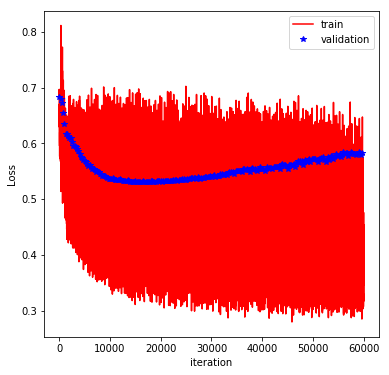

In [131]:
t = np.arange(iteration-1)

plt.figure(figsize = (6,6))
plt.plot(t, np.array(train_loss), 'r-', t[t % 250 == 0], np.array(validation_loss), 'b*')
plt.xlabel("iteration")
plt.ylabel("Loss")
plt.legend(['train', 'validation'], loc='upper right')
plt.show()

Plot Accuracies

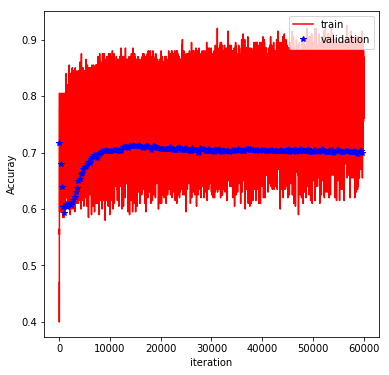

In [127]:
plt.figure(figsize = (6,6))

plt.plot(t, np.array(train_acc), 'r-', t[t % 250 == 0], validation_acc, 'b*')
plt.xlabel("iteration")
plt.ylabel("Accuray")
plt.legend(['train', 'validation'], loc='upper right')
plt.show()

In [128]:
test_acc = []

with tf.Session(graph=graph) as sess:
    # Restore
    saver.restore(sess, tf.train.latest_checkpoint('checkpoints'))
    test_state = sess.run(cell.zero_state(batch_size, tf.float32))
    
    for x_t, y_t in get_batches(X_test, y_test, batch_size):
        feed = {inputs_: x_t,
                labels_: y_t,
                keep_prob_: 1,
                initial_state: test_state}
        
        batch_acc, test_state = sess.run([accuracy, final_state], feed_dict=feed)
        test_acc.append(batch_acc)
    print("Test accuracy: {:.6f}".format(np.mean(test_acc)))

INFO:tensorflow:Restoring parameters from checkpoints\har-lstm.ckpt
Test accuracy: 0.676354


# conclusion

The Linear Regression score is 0.88, and the Logistic Regression accuracy is 68%, AUC of Logistic Regression is 0.57, After we use CNN model, the accuracy of predicing hit songs improves to 71.7%, AUC of CNN model is 0.74, which is much better than Logistic Regreesion, ad it means that by using CNN, the accuracy of predicting hit songs improves a lot. At last, we use the LSTM to predict the hit songs by using their time series data, and the accuracy is 67.6%, which means we can use this LSTM model to predict whether a song can be hit song in a given day.